## 영상 데이터 전처리
- Image Data Preparing

### 환경 구성

```python
pip install opencv-python

In [1]:
import os   # 내 컴퓨터의 라이브러리에 접근할 수 있도록 하는 라이브러리
import matplotlib.pyplot as plt # 이미지를 확인하기 위해 사용하는 라이브러리
import cv2  # OpenCV

### Dataset 정리

In [2]:
# 전체 data 불러오기 + train, val, test로 분할
import numpy as np
from sklearn.model_selection import train_test_split

def load_all_data(base_dir, img_size=(224, 224)):
    images = []
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']
    
    for category in categories:
        class_num = categories.index(category)  # ls.index(data): data의 index를 반환
        for subset in ['train', 'test', 'val']:
            # os.path.join을 사용해 현재 디렉토리의 경로를 불러옴
            # base_dir: .../datasets/Pneumonia | subset: /train or /test | category: /NORMAL or /PENUMONIA
            subset_dir = os.path.join(base_dir, subset, category) 
            for img in os.listdir(subset_dir):
                try:
                    img_path = os.path.join(subset_dir, img)    # image 파일 경로
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # image array로 불러오기 - array로 불러온다는게 어떤 의미?, GRAYSCALE로 읽는 이유?
                    new_array = cv2.resize(img_array, img_size) # img_size에 맞춰서 크기 조정
                    images.append(new_array)
                    labels.append(class_num)
                except Exception as e:
                    print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

분할 방식 설명

- 예제 데이터셋
X = ...  # 1000개의 샘플
y = ...  # 1000개의 라벨 (10개의 클래스, 각 클래스는 100개 샘플)

- 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
```
총 데이터셋: 1000개 샘플

•	테스트 데이터셋(20%): 200개 샘플
•	클래스 1: 20개 샘플
•	클래스 2: 20개 샘플
•	…
•	클래스 10: 20개 샘플

학습+검증 데이터셋(80%): 800개 샘플

•	클래스 1: 80개 샘플
•	클래스 2: 80개 샘플
•	…
•	클래스 10: 80개 샘플
```

In [3]:
def split_data(X, y, test_size=0.2, val_size=0.2):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size=test_size, 
                                                                stratify=y, 
                                                                random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                      y_train_val, 
                                                      test_size=val_size / (1 - test_size),     # 왜 이렇게 계산?
                                                      stratify=y_train_val,                     # stratify는 무슨 역할의 매개변수?
                                                      random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### Data 불러오기

In [6]:
# 현재 어느 디렉토리에 위치하고 있는지 체크하기
%pwd

'/Users/seoseondeok/study/ESG_AI'

In [4]:
base_dir = "datasets/Pneumonia" # 폴더 접근 경로
X, y = load_all_data(base_dir,)  # X에는 모든 이미지, y에는 모든 이미지에 대한 label종류(Class 종류)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)
print(f"Train data shape: {X_train.shape}, Train label shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation label shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test label shape: {y_test.shape}")


Train data shape: (3513, 224, 224), Train label shape: (3513,)
Validation data shape: (1171, 224, 224), Validation label shape: (1171,)
Test data shape: (1172, 224, 224), Test label shape: (1172,)


### Preparing tutorial

#### Resize

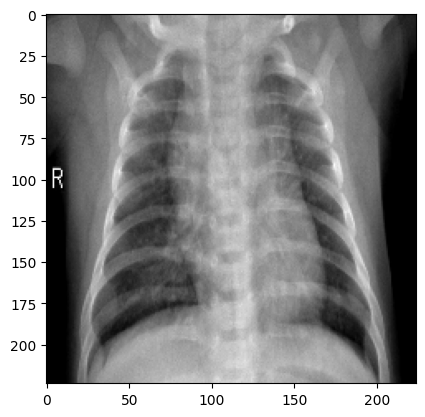

In [5]:
def resize_img(image, size=(224,224)):
    return cv2.resize(image, size)

resized_img = resize_img(X_train[708])
plt.imshow(resized_img, cmap='gray')
plt.show()

#### Histogram Equalization

밝고 어두운 부분을 더 분명하게 구분하기 위함

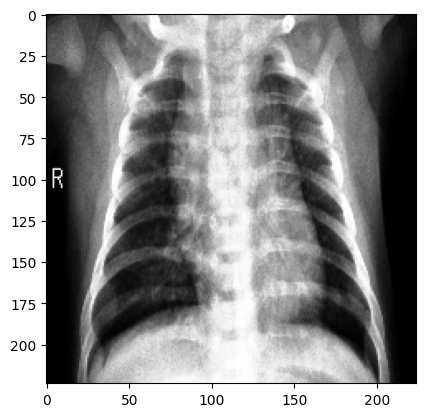

In [6]:
def histogram_img(image):
    return cv2.equalizeHist(image)

hist_img = histogram_img(resized_img)
plt.imshow(hist_img, cmap='gray')
plt.show()

#### Noise Reduction

번짐을 줄이기 위한 작업

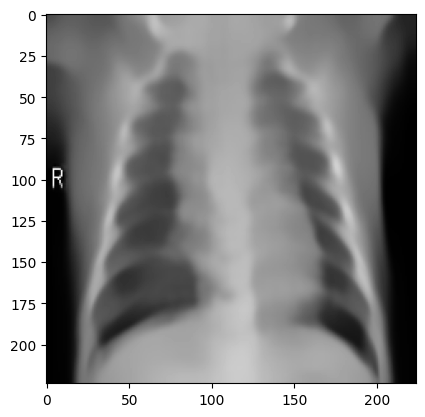

In [7]:
def noise_reduction(image):
    return cv2.fastNlMeansDenoising(image, None, 30, 7, 21) # window size 지정

# nr_image = noise_reduction(resized_img)
nr_image = noise_reduction(resized_img)
plt.imshow(nr_image, cmap='gray')
plt.show()

#### Image Normalization

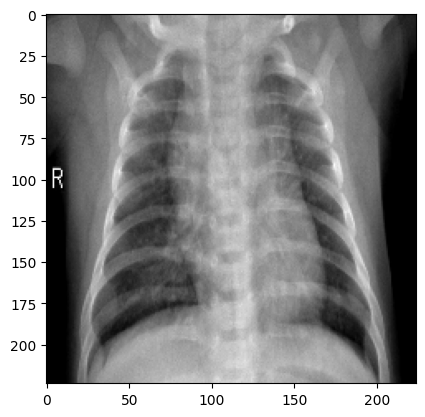

In [8]:
def normalize_image(image):
    # MinMax : Overfitting 방지
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

# MinMax Normalization 을 적용한다고 해도 육안으로 달라진 게 없어보임
normalized_img = normalize_image(resized_img)
plt.imshow(normalized_img, cmap='gray')
plt.show()

#### Edge Detection

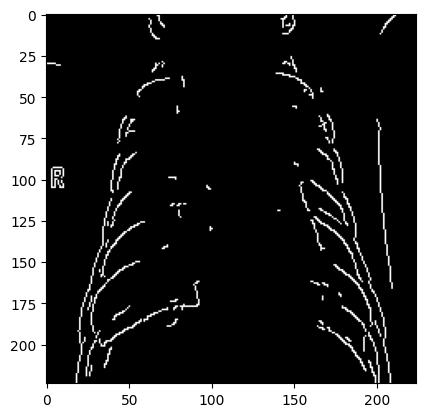

In [27]:
def detect_edge(image): # 명암의 범위가 100~200에 있는 것의 범위 표시
    return cv2.Canny(image, 150, 200)   # (image, min_threshold, max_threshold)

# 활용 -> 관절 등 굵은 선을 찾기 위한 목적
# 이미지에서 내가 탐지하고자 하는 target에 대한 경계를 설정하는 전처리 작업 시 사용
edges = detect_edge(X_train[708])
plt.imshow(edges, cmap='gray')
plt.show()

#### Blurring

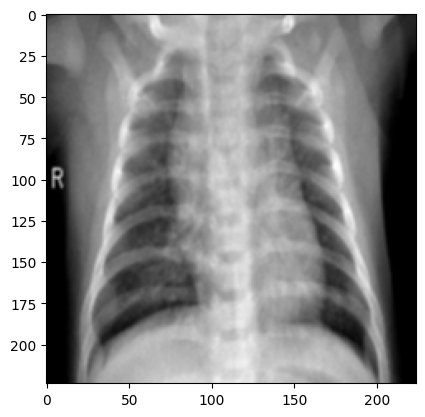

In [18]:
def blur_image(image):
    return cv2.GaussianBlur(image, (3,3), 0)    # (image, filter size, ?)

blurred_img = blur_image(X_train[708])
plt.imshow(blurred_img, cmap='gray')
plt.show()

#### Contour

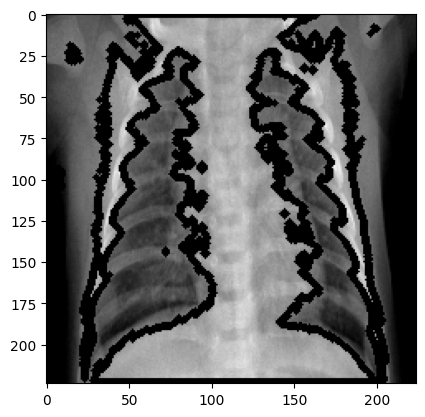

In [19]:
def contour_image(image):
    ret, thresh = cv2.threshold(image, 127,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = contour_image(X_train[708])
contour_img = cv2.drawContours(X_train[708].copy(), contours, -1, (0,255,0), 3)
plt.imshow(contour_img, cmap='gray')
plt.show()